In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import average_precision_score, accuracy_score, recall_score, precision_score, f1_score
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:

# Set the paths
root_folder = r"C:\ThesisMedia\CroppedPralines\Grouped_dataset\Thesis_Dataset_Resolution"
output_dir = r"C:\ThesisMedia\CroppedPralines\Grouped_dataset\Thesis_Dataset_Resolution\Outputs"

# Set the device (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the resolutions to study
resolutions = ["2160p", "1080p", "720p", "480p", "360p"] 



In [5]:
batch_size = 64
num_epochs = 10
num_classes = 2
window_size = 3  # Smoothing plot curve
num_workers = 8

In [6]:
# Define the models to test
models_to_test = [
    ('vgg11_bn', models.vgg11_bn(pretrained=True)),
    ('ResNet_bn', models.resnet50(pretrained=True)),
    ('Inception_bn', models.inception_v3(pretrained=True)),
    ('EfficientNet_bn', EfficientNet.from_pretrained('efficientnet-b0')),
    ('MobileNet_bn', models.mobilenet_v2(pretrained=True))
]

In [7]:
def get_transform(model_name):
    if model_name == 'Inception_bn':
        transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    else:
        transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform

In [8]:
def create_data_loader(dataset, batch_size, shuffle):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=False
    )

In [9]:
def modify_classification_layer(model, model_name, num_classes):
    # Modify the classification layer for the model
        if model_name == 'EfficientNet_bn':
            model._fc = nn.Sequential(
                nn.Linear(in_features=1280, out_features=512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.5),  # Add dropout layer with dropout rate of 0.5
                nn.Linear(in_features=512, out_features=num_classes)
            )
        elif model_name == 'MobileNet_bn':
            num_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features=num_features, out_features=num_classes)
            
        elif model_name == 'ResNet_bn' or model_name == 'Inception_bn':
            num_features = model.fc.in_features
            model.fc = nn.Linear(in_features=num_features, out_features=num_classes)
        else:
            num_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features=num_features, out_features=num_classes)  # 2 classes: Good and Bad


In [10]:
def train_model(model, train_loader, val_loader, model_name, train_res, num_epochs):

    global train_results_df

    # Modify the classification layer for the model
    modify_classification_layer(model, model_name, num_classes)
    
    model.to(device)

    # Define your loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    train_map_values = []
    val_map_values = []
    train_accuracy_values = []
    val_accuracy_values = []
    y_true_train = []
    y_pred_train = []
    y_true_val = []
    y_pred_val = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        y_true_train = []
        y_pred_train = []

        # Create a progress bar for the training loop
        progress_bar = tqdm(train_loader, desc=f"Model: {model_name} - Training Res: {train_res} - Epoch {epoch + 1}/{num_epochs}", leave=False)

        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            if model_name == 'Inception_bn':
                outputs, _ = model(images)
            else:
                outputs = model(images)

            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Update the progress bar with the current loss
            progress_bar.set_postfix({"Loss": loss.item()})

            # Store the true labels and predicted labels for mAP calculation
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        epoch_train_accuracy = train_correct / train_total
        train_map = average_precision_score(y_true_train, y_pred_train)
        train_map_values.append(train_map)
        train_accuracy_values.append(epoch_train_accuracy)
        print(f"Training - {train_res} - Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {epoch_loss:.4f} - Training Accuracy: {epoch_train_accuracy:.4f}")

        if epoch == 0 or train_map > max(train_map_values[:-1]):
            torch.save(model.state_dict(), f'{output_dir}/Model_{model_name}_{train_res}.pt')

        # Clear GPU cache to free up memory
        torch.cuda.empty_cache()

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_correct = 0
        val_total = 0
        y_true_val = []
        y_pred_val = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)

                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Store the true labels and predicted labels for mAP calculation
                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(predicted.cpu().numpy())

        epoch_val_accuracy = val_correct / val_total
        val_map = average_precision_score(y_true_val, y_pred_val)
        val_map_values.append(val_map)
        val_accuracy = accuracy_score(y_true_val, y_pred_val)
        val_accuracy_values.append(val_accuracy)
        print(f"Validation - {train_res} - Epoch [{epoch + 1}/{num_epochs}] - Validation Accuracy: {epoch_val_accuracy:.4f}")

        # Clear GPU cache to free up memory
        torch.cuda.empty_cache()

    end_time = time.time()
    global training_duration
    training_duration = end_time - start_time

    # Smooth the mAP curve using a moving average with a window size of 5
    smoothed_train_map_values = np.convolve(train_map_values, np.ones(window_size) / window_size, mode='valid')
    smoothed_val_map_values = np.convolve(val_map_values, np.ones(window_size) / window_size, mode='valid')

    # Plot the training and validation mAP graph
    plt.plot(range(window_size, num_epochs + 1), smoothed_train_map_values, label=f'Training')
    plt.plot(range(window_size, num_epochs + 1), smoothed_val_map_values, label=f'Validation')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title(f'mAP for {model_name} - Resolution: {train_res}')
    plt.legend(loc='upper left')
    plt.savefig(f'{output_dir}/mAP_Plot_Resolution_training/{model_name}_Res_{train_res}_mAP_graph.png')
    plt.close()
    
    train_result = pd.DataFrame({
            'Model': model_name,
            'Train_resolution': train_res,
            'Training_Duration':training_duration,
            'Train_mAP':train_map_values[-1],
            'val_mAP': val_map_values[-1],
            'Train_Accuracy': train_accuracy_values[-1],
            'val_Accuracy': val_accuracy_values[-1]
    }, index=[0])
    
    train_results_df = pd.concat([train_results_df, train_result], ignore_index=True)

    # Clear GPU cache to free up memory
    torch.cuda.empty_cache()

In [11]:
def test_model(model, test_loader, model_name, train_res, test_res):
    global test_results_df
    model.eval()  # Set model to evaluation mode
    test_y_true = []
    test_y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            # Store the true labels and predicted labels for mAP calculation
            test_y_true.extend(labels.cpu().numpy())
            test_y_pred.extend(predicted.cpu().numpy())

    # Calculate metrics for the test set
    test_accuracy = accuracy_score(test_y_true, test_y_pred)
    test_recall = recall_score(test_y_true, test_y_pred)
    test_precision = precision_score(test_y_true, test_y_pred)
    test_f1_score = f1_score(test_y_true, test_y_pred)
    test_map = average_precision_score(test_y_true, test_y_pred)

    test_result = pd.DataFrame({
            'Model': model_name,
            'Train_resolution': train_res,
            'Test_resolution': test_res,
            'Test_mAP': test_map,
            'Test_Accuracy': test_accuracy,
            'Test_Recall': test_recall,
            'Test_Precision':test_precision,
            'Test_F1_Score': test_f1_score
    }, index=[0])

    test_results_df = pd.concat([test_results_df, test_result], ignore_index=True)


In [12]:
def main():
    global train_results_df
    global test_results_df
    train_results_df = pd.DataFrame(columns=['Model', 'Train_resolution','Training_Duration', 'Train_mAP',
                                             'Train_Accuracy', 'val_Accuracy', 'val_mAP'])
    test_results_df = pd.DataFrame(columns=['Model', 'Train_resolution', 'Test_resolution', 
                          'Test_mAP', 'Test_Accuracy', 'Test_Recall', 'Test_Precision', 'Test_F1_Score'])
    # Separate DataFrames to store training mAP values for each model
    training_mAP_data = {}

    for model_name, model in models_to_test:
        model = model.to(device)

        for train_res in resolutions:
            # Load train dataset
            train_dataset = ImageFolder(root=os.path.join(root_folder, f'Train_{train_res}'), transform=get_transform(model_name))

             # Split the dataset into training and validation sets (80-20 split)
            train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

            train_loader = create_data_loader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = create_data_loader(val_dataset, batch_size=batch_size, shuffle=False)

            # Train the model and plot the training and validation mAP for the training resolution
            train_model(model, train_loader, val_loader, model_name, train_res, num_epochs)

            # Load test datasets for all resolutions
            for test_res in resolutions:
                test_dataset = ImageFolder(root=os.path.join(root_folder, f'Test_{test_res}'), transform=get_transform(model_name))
                test_loader = create_data_loader(test_dataset, batch_size=batch_size, shuffle=False)
                print(f"Testing - {model_name} Train Res: {train_res}, Test Res: {test_res} - size: {len(test_dataset)}")

                # Test the model on the test dataset
                model.load_state_dict(torch.load(f'{output_dir}/Model_{model_name}_{train_res}.pt'))
                model.to(device)
                test_model(model, test_loader, model_name, train_res, test_res)

        # Clear GPU cache to free up memory
        torch.cuda.empty_cache()

    train_results_df.to_excel(f'{output_dir}/Training_results.xlsx', index=False)
    test_results_df.to_excel(f'{output_dir}/Testing_results.xlsx', index=False)


In [13]:
if __name__ == '__main__':
    torch.multiprocessing.freeze_support()
    main()

Training - 2160p - Epoch [1/10] - Training Loss: 1.1237 - Training Accuracy: 0.8263
Validation - 2160p - Epoch [1/10] - Validation Accuracy: 0.9425


Training - 2160p - Epoch [2/10] - Training Loss: 0.1643 - Training Accuracy: 0.9550
Validation - 2160p - Epoch [2/10] - Validation Accuracy: 0.9425


Training - 2160p - Epoch [3/10] - Training Loss: 0.0872 - Training Accuracy: 0.9738
Validation - 2160p - Epoch [3/10] - Validation Accuracy: 0.9650


Training - 2160p - Epoch [4/10] - Training Loss: 0.0657 - Training Accuracy: 0.9738
Validation - 2160p - Epoch [4/10] - Validation Accuracy: 0.9525


Training - 2160p - Epoch [5/10] - Training Loss: 0.0415 - Training Accuracy: 0.9869
Validation - 2160p - Epoch [5/10] - Validation Accuracy: 0.9675


Training - 2160p - Epoch [6/10] - Training Loss: 0.0091 - Training Accuracy: 0.9969
Validation - 2160p - Epoch [6/10] - Validation Accuracy: 0.9825


Training - 2160p - Epoch [7/10] - Training Loss: 0.0726 - Training Accuracy: 0.9769
Validation - 2160p - Epoch [7/10] - Validation Accuracy: 0.9625


Training - 2160p - Epoch [8/10] - Training Loss: 0.0445 - Training Accuracy: 0.9850
Validation - 2160p - Epoch [8/10] - Validation Accuracy: 0.9650


Training - 2160p - Epoch [9/10] - Training Loss: 0.0446 - Training Accuracy: 0.9856
Validation - 2160p - Epoch [9/10] - Validation Accuracy: 0.9775


Training - 2160p - Epoch [10/10] - Training Loss: 0.0132 - Training Accuracy: 0.9938
Validation - 2160p - Epoch [10/10] - Validation Accuracy: 0.9700
Testing - vgg11_bn Train Res: 2160p, Test Res: 2160p - size: 600
Testing - vgg11_bn Train Res: 2160p, Test Res: 1080p - size: 600
Testing - vgg11_bn Train Res: 2160p, Test Res: 720p - size: 600
Testing - vgg11_bn Train Res: 2160p, Test Res: 480p - size: 600
Testing - vgg11_bn Train Res: 2160p, Test Res: 360p - size: 600


Training - 1080p - Epoch [1/10] - Training Loss: 0.6060 - Training Accuracy: 0.7338
Validation - 1080p - Epoch [1/10] - Validation Accuracy: 0.7350


Training - 1080p - Epoch [2/10] - Training Loss: 0.4622 - Training Accuracy: 0.8031
Validation - 1080p - Epoch [2/10] - Validation Accuracy: 0.7975


Training - 1080p - Epoch [3/10] - Training Loss: 0.3796 - Training Accuracy: 0.8350
Validation - 1080p - Epoch [3/10] - Validation Accuracy: 0.7100


Training - 1080p - Epoch [4/10] - Training Loss: 0.3432 - Training Accuracy: 0.8462
Validation - 1080p - Epoch [4/10] - Validation Accuracy: 0.8750


Training - 1080p - Epoch [5/10] - Training Loss: 0.3004 - Training Accuracy: 0.8794
Validation - 1080p - Epoch [5/10] - Validation Accuracy: 0.7100


Training - 1080p - Epoch [6/10] - Training Loss: 0.2738 - Training Accuracy: 0.8900
Validation - 1080p - Epoch [6/10] - Validation Accuracy: 0.9025


Training - 1080p - Epoch [7/10] - Training Loss: 0.2747 - Training Accuracy: 0.8994
Validation - 1080p - Epoch [7/10] - Validation Accuracy: 0.8950


Training - 1080p - Epoch [8/10] - Training Loss: 0.2432 - Training Accuracy: 0.9050
Validation - 1080p - Epoch [8/10] - Validation Accuracy: 0.7875


Training - 1080p - Epoch [9/10] - Training Loss: 0.2351 - Training Accuracy: 0.9044
Validation - 1080p - Epoch [9/10] - Validation Accuracy: 0.9000


Training - 1080p - Epoch [10/10] - Training Loss: 0.1934 - Training Accuracy: 0.9237
Validation - 1080p - Epoch [10/10] - Validation Accuracy: 0.9000
Testing - vgg11_bn Train Res: 1080p, Test Res: 2160p - size: 600
Testing - vgg11_bn Train Res: 1080p, Test Res: 1080p - size: 600
Testing - vgg11_bn Train Res: 1080p, Test Res: 720p - size: 600
Testing - vgg11_bn Train Res: 1080p, Test Res: 480p - size: 600
Testing - vgg11_bn Train Res: 1080p, Test Res: 360p - size: 600


Training - 720p - Epoch [1/10] - Training Loss: 0.3131 - Training Accuracy: 0.8769
Validation - 720p - Epoch [1/10] - Validation Accuracy: 0.9025


Training - 720p - Epoch [2/10] - Training Loss: 0.2323 - Training Accuracy: 0.9119
Validation - 720p - Epoch [2/10] - Validation Accuracy: 0.8825


Training - 720p - Epoch [3/10] - Training Loss: 0.1690 - Training Accuracy: 0.9363
Validation - 720p - Epoch [3/10] - Validation Accuracy: 0.7075


Training - 720p - Epoch [4/10] - Training Loss: 0.1161 - Training Accuracy: 0.9619
Validation - 720p - Epoch [4/10] - Validation Accuracy: 0.9600


Training - 720p - Epoch [5/10] - Training Loss: 0.0898 - Training Accuracy: 0.9694
Validation - 720p - Epoch [5/10] - Validation Accuracy: 0.9150


Training - 720p - Epoch [6/10] - Training Loss: 0.0865 - Training Accuracy: 0.9731
Validation - 720p - Epoch [6/10] - Validation Accuracy: 0.9625


Training - 720p - Epoch [7/10] - Training Loss: 0.0649 - Training Accuracy: 0.9762
Validation - 720p - Epoch [7/10] - Validation Accuracy: 0.9275


Training - 720p - Epoch [8/10] - Training Loss: 0.0515 - Training Accuracy: 0.9794
Validation - 720p - Epoch [8/10] - Validation Accuracy: 0.9675


Training - 720p - Epoch [9/10] - Training Loss: 0.0293 - Training Accuracy: 0.9888
Validation - 720p - Epoch [9/10] - Validation Accuracy: 0.9750


Training - 720p - Epoch [10/10] - Training Loss: 0.0428 - Training Accuracy: 0.9862
Validation - 720p - Epoch [10/10] - Validation Accuracy: 0.9875
Testing - vgg11_bn Train Res: 720p, Test Res: 2160p - size: 600
Testing - vgg11_bn Train Res: 720p, Test Res: 1080p - size: 600
Testing - vgg11_bn Train Res: 720p, Test Res: 720p - size: 600
Testing - vgg11_bn Train Res: 720p, Test Res: 480p - size: 600
Testing - vgg11_bn Train Res: 720p, Test Res: 360p - size: 600


Training - 480p - Epoch [1/10] - Training Loss: 0.1604 - Training Accuracy: 0.9381
Validation - 480p - Epoch [1/10] - Validation Accuracy: 0.9475


Training - 480p - Epoch [2/10] - Training Loss: 0.0656 - Training Accuracy: 0.9788
Validation - 480p - Epoch [2/10] - Validation Accuracy: 0.9625


Training - 480p - Epoch [3/10] - Training Loss: 0.0568 - Training Accuracy: 0.9819
Validation - 480p - Epoch [3/10] - Validation Accuracy: 0.7400


Training - 480p - Epoch [4/10] - Training Loss: 0.0666 - Training Accuracy: 0.9744
Validation - 480p - Epoch [4/10] - Validation Accuracy: 0.9675


Training - 480p - Epoch [5/10] - Training Loss: 0.0262 - Training Accuracy: 0.9900
Validation - 480p - Epoch [5/10] - Validation Accuracy: 0.9675


Training - 480p - Epoch [6/10] - Training Loss: 0.0300 - Training Accuracy: 0.9900
Validation - 480p - Epoch [6/10] - Validation Accuracy: 0.9400


Training - 480p - Epoch [7/10] - Training Loss: 0.0215 - Training Accuracy: 0.9912
Validation - 480p - Epoch [7/10] - Validation Accuracy: 0.9600


Training - 480p - Epoch [8/10] - Training Loss: 0.0168 - Training Accuracy: 0.9956
Validation - 480p - Epoch [8/10] - Validation Accuracy: 0.9675


Training - 480p - Epoch [9/10] - Training Loss: 0.0269 - Training Accuracy: 0.9900
Validation - 480p - Epoch [9/10] - Validation Accuracy: 0.9450


Training - 480p - Epoch [10/10] - Training Loss: 0.0749 - Training Accuracy: 0.9806
Validation - 480p - Epoch [10/10] - Validation Accuracy: 0.9575
Testing - vgg11_bn Train Res: 480p, Test Res: 2160p - size: 600
Testing - vgg11_bn Train Res: 480p, Test Res: 1080p - size: 600
Testing - vgg11_bn Train Res: 480p, Test Res: 720p - size: 600
Testing - vgg11_bn Train Res: 480p, Test Res: 480p - size: 600
Testing - vgg11_bn Train Res: 480p, Test Res: 360p - size: 600


Training - 360p - Epoch [1/10] - Training Loss: 0.1823 - Training Accuracy: 0.9231
Validation - 360p - Epoch [1/10] - Validation Accuracy: 0.9700


Training - 360p - Epoch [2/10] - Training Loss: 0.0574 - Training Accuracy: 0.9800
Validation - 360p - Epoch [2/10] - Validation Accuracy: 0.9650


Training - 360p - Epoch [3/10] - Training Loss: 0.0343 - Training Accuracy: 0.9869
Validation - 360p - Epoch [3/10] - Validation Accuracy: 0.9675


Training - 360p - Epoch [4/10] - Training Loss: 0.0468 - Training Accuracy: 0.9850
Validation - 360p - Epoch [4/10] - Validation Accuracy: 0.9575


Training - 360p - Epoch [5/10] - Training Loss: 0.0330 - Training Accuracy: 0.9900
Validation - 360p - Epoch [5/10] - Validation Accuracy: 0.9650


Training - 360p - Epoch [6/10] - Training Loss: 0.0421 - Training Accuracy: 0.9881
Validation - 360p - Epoch [6/10] - Validation Accuracy: 0.9750


Training - 360p - Epoch [7/10] - Training Loss: 0.0296 - Training Accuracy: 0.9900
Validation - 360p - Epoch [7/10] - Validation Accuracy: 0.9725


Training - 360p - Epoch [8/10] - Training Loss: 0.0186 - Training Accuracy: 0.9925
Validation - 360p - Epoch [8/10] - Validation Accuracy: 0.9350


Training - 360p - Epoch [9/10] - Training Loss: 0.0226 - Training Accuracy: 0.9912
Validation - 360p - Epoch [9/10] - Validation Accuracy: 0.9100


Training - 360p - Epoch [10/10] - Training Loss: 0.0339 - Training Accuracy: 0.9906
Validation - 360p - Epoch [10/10] - Validation Accuracy: 0.9525
Testing - vgg11_bn Train Res: 360p, Test Res: 2160p - size: 600
Testing - vgg11_bn Train Res: 360p, Test Res: 1080p - size: 600
Testing - vgg11_bn Train Res: 360p, Test Res: 720p - size: 600
Testing - vgg11_bn Train Res: 360p, Test Res: 480p - size: 600
Testing - vgg11_bn Train Res: 360p, Test Res: 360p - size: 600


Training - 2160p - Epoch [1/10] - Training Loss: 0.2516 - Training Accuracy: 0.9056
Validation - 2160p - Epoch [1/10] - Validation Accuracy: 0.7450


Training - 2160p - Epoch [2/10] - Training Loss: 0.0775 - Training Accuracy: 0.9712
Validation - 2160p - Epoch [2/10] - Validation Accuracy: 0.8500


Training - 2160p - Epoch [3/10] - Training Loss: 0.0674 - Training Accuracy: 0.9775
Validation - 2160p - Epoch [3/10] - Validation Accuracy: 0.9750


Training - 2160p - Epoch [4/10] - Training Loss: 0.0377 - Training Accuracy: 0.9850
Validation - 2160p - Epoch [4/10] - Validation Accuracy: 0.9475


Training - 2160p - Epoch [5/10] - Training Loss: 0.0407 - Training Accuracy: 0.9856
Validation - 2160p - Epoch [5/10] - Validation Accuracy: 0.9750


Training - 2160p - Epoch [6/10] - Training Loss: 0.0232 - Training Accuracy: 0.9919
Validation - 2160p - Epoch [6/10] - Validation Accuracy: 0.9425


Training - 2160p - Epoch [7/10] - Training Loss: 0.0355 - Training Accuracy: 0.9906
Validation - 2160p - Epoch [7/10] - Validation Accuracy: 0.9125


Training - 2160p - Epoch [8/10] - Training Loss: 0.0239 - Training Accuracy: 0.9938
Validation - 2160p - Epoch [8/10] - Validation Accuracy: 0.9700


Training - 2160p - Epoch [9/10] - Training Loss: 0.0279 - Training Accuracy: 0.9888
Validation - 2160p - Epoch [9/10] - Validation Accuracy: 0.9600


Training - 2160p - Epoch [10/10] - Training Loss: 0.0368 - Training Accuracy: 0.9838
Validation - 2160p - Epoch [10/10] - Validation Accuracy: 0.9575
Testing - ResNet_bn Train Res: 2160p, Test Res: 2160p - size: 600
Testing - ResNet_bn Train Res: 2160p, Test Res: 1080p - size: 600
Testing - ResNet_bn Train Res: 2160p, Test Res: 720p - size: 600
Testing - ResNet_bn Train Res: 2160p, Test Res: 480p - size: 600
Testing - ResNet_bn Train Res: 2160p, Test Res: 360p - size: 600


Training - 1080p - Epoch [1/10] - Training Loss: 0.1108 - Training Accuracy: 0.9650
Validation - 1080p - Epoch [1/10] - Validation Accuracy: 0.8525


Training - 1080p - Epoch [2/10] - Training Loss: 0.0406 - Training Accuracy: 0.9856
Validation - 1080p - Epoch [2/10] - Validation Accuracy: 0.9200


Training - 1080p - Epoch [3/10] - Training Loss: 0.0307 - Training Accuracy: 0.9888
Validation - 1080p - Epoch [3/10] - Validation Accuracy: 0.9575


Training - 1080p - Epoch [4/10] - Training Loss: 0.0531 - Training Accuracy: 0.9806
Validation - 1080p - Epoch [4/10] - Validation Accuracy: 0.8975


Training - 1080p - Epoch [5/10] - Training Loss: 0.0256 - Training Accuracy: 0.9894
Validation - 1080p - Epoch [5/10] - Validation Accuracy: 0.9200


Training - 1080p - Epoch [6/10] - Training Loss: 0.0107 - Training Accuracy: 0.9969
Validation - 1080p - Epoch [6/10] - Validation Accuracy: 0.9400


Training - 1080p - Epoch [7/10] - Training Loss: 0.0276 - Training Accuracy: 0.9919
Validation - 1080p - Epoch [7/10] - Validation Accuracy: 0.9675


Training - 1080p - Epoch [8/10] - Training Loss: 0.0283 - Training Accuracy: 0.9931
Validation - 1080p - Epoch [8/10] - Validation Accuracy: 0.9575


Training - 1080p - Epoch [9/10] - Training Loss: 0.0164 - Training Accuracy: 0.9944
Validation - 1080p - Epoch [9/10] - Validation Accuracy: 0.9700


Training - 1080p - Epoch [10/10] - Training Loss: 0.0165 - Training Accuracy: 0.9956
Validation - 1080p - Epoch [10/10] - Validation Accuracy: 0.9675
Testing - ResNet_bn Train Res: 1080p, Test Res: 2160p - size: 600
Testing - ResNet_bn Train Res: 1080p, Test Res: 1080p - size: 600
Testing - ResNet_bn Train Res: 1080p, Test Res: 720p - size: 600
Testing - ResNet_bn Train Res: 1080p, Test Res: 480p - size: 600
Testing - ResNet_bn Train Res: 1080p, Test Res: 360p - size: 600


Training - 720p - Epoch [1/10] - Training Loss: 0.1122 - Training Accuracy: 0.9556
Validation - 720p - Epoch [1/10] - Validation Accuracy: 0.9200


Training - 720p - Epoch [2/10] - Training Loss: 0.0450 - Training Accuracy: 0.9825
Validation - 720p - Epoch [2/10] - Validation Accuracy: 0.9400


Training - 720p - Epoch [3/10] - Training Loss: 0.0232 - Training Accuracy: 0.9919
Validation - 720p - Epoch [3/10] - Validation Accuracy: 0.9675


Training - 720p - Epoch [4/10] - Training Loss: 0.0310 - Training Accuracy: 0.9881
Validation - 720p - Epoch [4/10] - Validation Accuracy: 0.9600


Training - 720p - Epoch [5/10] - Training Loss: 0.0311 - Training Accuracy: 0.9894
Validation - 720p - Epoch [5/10] - Validation Accuracy: 0.9425


Training - 720p - Epoch [6/10] - Training Loss: 0.0168 - Training Accuracy: 0.9944
Validation - 720p - Epoch [6/10] - Validation Accuracy: 0.9725


Training - 720p - Epoch [7/10] - Training Loss: 0.0211 - Training Accuracy: 0.9944
Validation - 720p - Epoch [7/10] - Validation Accuracy: 0.9750


Training - 720p - Epoch [8/10] - Training Loss: 0.0123 - Training Accuracy: 0.9950
Validation - 720p - Epoch [8/10] - Validation Accuracy: 0.9775


Training - 720p - Epoch [9/10] - Training Loss: 0.0041 - Training Accuracy: 0.9975
Validation - 720p - Epoch [9/10] - Validation Accuracy: 0.9750


Training - 720p - Epoch [10/10] - Training Loss: 0.0067 - Training Accuracy: 0.9981
Validation - 720p - Epoch [10/10] - Validation Accuracy: 0.9275
Testing - ResNet_bn Train Res: 720p, Test Res: 2160p - size: 600
Testing - ResNet_bn Train Res: 720p, Test Res: 1080p - size: 600
Testing - ResNet_bn Train Res: 720p, Test Res: 720p - size: 600
Testing - ResNet_bn Train Res: 720p, Test Res: 480p - size: 600
Testing - ResNet_bn Train Res: 720p, Test Res: 360p - size: 600


Training - 480p - Epoch [1/10] - Training Loss: 0.1081 - Training Accuracy: 0.9550
Validation - 480p - Epoch [1/10] - Validation Accuracy: 0.9550


Training - 480p - Epoch [2/10] - Training Loss: 0.0665 - Training Accuracy: 0.9744
Validation - 480p - Epoch [2/10] - Validation Accuracy: 0.9625


Training - 480p - Epoch [3/10] - Training Loss: 0.0329 - Training Accuracy: 0.9875
Validation - 480p - Epoch [3/10] - Validation Accuracy: 0.9750


Training - 480p - Epoch [4/10] - Training Loss: 0.0201 - Training Accuracy: 0.9956
Validation - 480p - Epoch [4/10] - Validation Accuracy: 0.9500


Training - 480p - Epoch [5/10] - Training Loss: 0.0053 - Training Accuracy: 0.9988
Validation - 480p - Epoch [5/10] - Validation Accuracy: 0.9800


Training - 480p - Epoch [6/10] - Training Loss: 0.0097 - Training Accuracy: 0.9975
Validation - 480p - Epoch [6/10] - Validation Accuracy: 0.9675


Training - 480p - Epoch [7/10] - Training Loss: 0.0063 - Training Accuracy: 0.9975
Validation - 480p - Epoch [7/10] - Validation Accuracy: 0.9600


Training - 480p - Epoch [8/10] - Training Loss: 0.0265 - Training Accuracy: 0.9931
Validation - 480p - Epoch [8/10] - Validation Accuracy: 0.9550


Training - 480p - Epoch [9/10] - Training Loss: 0.0497 - Training Accuracy: 0.9838
Validation - 480p - Epoch [9/10] - Validation Accuracy: 0.9650


Training - 480p - Epoch [10/10] - Training Loss: 0.0204 - Training Accuracy: 0.9925
Validation - 480p - Epoch [10/10] - Validation Accuracy: 0.9700
Testing - ResNet_bn Train Res: 480p, Test Res: 2160p - size: 600
Testing - ResNet_bn Train Res: 480p, Test Res: 1080p - size: 600
Testing - ResNet_bn Train Res: 480p, Test Res: 720p - size: 600
Testing - ResNet_bn Train Res: 480p, Test Res: 480p - size: 600
Testing - ResNet_bn Train Res: 480p, Test Res: 360p - size: 600


Training - 360p - Epoch [1/10] - Training Loss: 0.1246 - Training Accuracy: 0.9500
Validation - 360p - Epoch [1/10] - Validation Accuracy: 0.9600


Training - 360p - Epoch [2/10] - Training Loss: 0.0516 - Training Accuracy: 0.9800
Validation - 360p - Epoch [2/10] - Validation Accuracy: 0.9500


Training - 360p - Epoch [3/10] - Training Loss: 0.0385 - Training Accuracy: 0.9825
Validation - 360p - Epoch [3/10] - Validation Accuracy: 0.9575


Training - 360p - Epoch [4/10] - Training Loss: 0.0442 - Training Accuracy: 0.9812
Validation - 360p - Epoch [4/10] - Validation Accuracy: 0.9625


Training - 360p - Epoch [5/10] - Training Loss: 0.0359 - Training Accuracy: 0.9869
Validation - 360p - Epoch [5/10] - Validation Accuracy: 0.9500


Training - 360p - Epoch [6/10] - Training Loss: 0.0200 - Training Accuracy: 0.9950
Validation - 360p - Epoch [6/10] - Validation Accuracy: 0.9800


Training - 360p - Epoch [7/10] - Training Loss: 0.0130 - Training Accuracy: 0.9956
Validation - 360p - Epoch [7/10] - Validation Accuracy: 0.9775


Training - 360p - Epoch [8/10] - Training Loss: 0.0076 - Training Accuracy: 0.9975
Validation - 360p - Epoch [8/10] - Validation Accuracy: 0.9700


Training - 360p - Epoch [9/10] - Training Loss: 0.0201 - Training Accuracy: 0.9938
Validation - 360p - Epoch [9/10] - Validation Accuracy: 0.9525


Training - 360p - Epoch [10/10] - Training Loss: 0.0496 - Training Accuracy: 0.9838
Validation - 360p - Epoch [10/10] - Validation Accuracy: 0.9600
Testing - ResNet_bn Train Res: 360p, Test Res: 2160p - size: 600
Testing - ResNet_bn Train Res: 360p, Test Res: 1080p - size: 600
Testing - ResNet_bn Train Res: 360p, Test Res: 720p - size: 600
Testing - ResNet_bn Train Res: 360p, Test Res: 480p - size: 600
Testing - ResNet_bn Train Res: 360p, Test Res: 360p - size: 600


Training - 2160p - Epoch [1/10] - Training Loss: 0.2384 - Training Accuracy: 0.9056
Validation - 2160p - Epoch [1/10] - Validation Accuracy: 0.6375


Training - 2160p - Epoch [2/10] - Training Loss: 0.0693 - Training Accuracy: 0.9756
Validation - 2160p - Epoch [2/10] - Validation Accuracy: 0.9775


Training - 2160p - Epoch [3/10] - Training Loss: 0.0530 - Training Accuracy: 0.9800
Validation - 2160p - Epoch [3/10] - Validation Accuracy: 0.8650


Training - 2160p - Epoch [4/10] - Training Loss: 0.0209 - Training Accuracy: 0.9938
Validation - 2160p - Epoch [4/10] - Validation Accuracy: 0.8075


Training - 2160p - Epoch [5/10] - Training Loss: 0.0320 - Training Accuracy: 0.9881
Validation - 2160p - Epoch [5/10] - Validation Accuracy: 0.9800


Training - 2160p - Epoch [6/10] - Training Loss: 0.0173 - Training Accuracy: 0.9944
Validation - 2160p - Epoch [6/10] - Validation Accuracy: 0.9075


Training - 2160p - Epoch [7/10] - Training Loss: 0.0195 - Training Accuracy: 0.9938
Validation - 2160p - Epoch [7/10] - Validation Accuracy: 0.9500


Training - 2160p - Epoch [8/10] - Training Loss: 0.0103 - Training Accuracy: 0.9962
Validation - 2160p - Epoch [8/10] - Validation Accuracy: 0.9800


Training - 2160p - Epoch [9/10] - Training Loss: 0.0105 - Training Accuracy: 0.9981
Validation - 2160p - Epoch [9/10] - Validation Accuracy: 0.9225


Training - 2160p - Epoch [10/10] - Training Loss: 0.0125 - Training Accuracy: 0.9969
Validation - 2160p - Epoch [10/10] - Validation Accuracy: 0.9775
Testing - Inception_bn Train Res: 2160p, Test Res: 2160p - size: 600
Testing - Inception_bn Train Res: 2160p, Test Res: 1080p - size: 600
Testing - Inception_bn Train Res: 2160p, Test Res: 720p - size: 600
Testing - Inception_bn Train Res: 2160p, Test Res: 480p - size: 600
Testing - Inception_bn Train Res: 2160p, Test Res: 360p - size: 600


Training - 1080p - Epoch [1/10] - Training Loss: 0.1017 - Training Accuracy: 0.9544
Validation - 1080p - Epoch [1/10] - Validation Accuracy: 0.8850


Training - 1080p - Epoch [2/10] - Training Loss: 0.0346 - Training Accuracy: 0.9888
Validation - 1080p - Epoch [2/10] - Validation Accuracy: 0.9650


Training - 1080p - Epoch [3/10] - Training Loss: 0.0285 - Training Accuracy: 0.9900
Validation - 1080p - Epoch [3/10] - Validation Accuracy: 0.9575


Training - 1080p - Epoch [4/10] - Training Loss: 0.0255 - Training Accuracy: 0.9931
Validation - 1080p - Epoch [4/10] - Validation Accuracy: 0.9750


Training - 1080p - Epoch [5/10] - Training Loss: 0.0385 - Training Accuracy: 0.9862
Validation - 1080p - Epoch [5/10] - Validation Accuracy: 0.9450


Training - 1080p - Epoch [6/10] - Training Loss: 0.0265 - Training Accuracy: 0.9931
Validation - 1080p - Epoch [6/10] - Validation Accuracy: 0.9425


Training - 1080p - Epoch [7/10] - Training Loss: 0.0205 - Training Accuracy: 0.9925
Validation - 1080p - Epoch [7/10] - Validation Accuracy: 0.9650


Training - 1080p - Epoch [8/10] - Training Loss: 0.0188 - Training Accuracy: 0.9938
Validation - 1080p - Epoch [8/10] - Validation Accuracy: 0.9700


Training - 1080p - Epoch [9/10] - Training Loss: 0.0064 - Training Accuracy: 0.9975
Validation - 1080p - Epoch [9/10] - Validation Accuracy: 0.9725


Training - 1080p - Epoch [10/10] - Training Loss: 0.0084 - Training Accuracy: 0.9981
Validation - 1080p - Epoch [10/10] - Validation Accuracy: 0.9700
Testing - Inception_bn Train Res: 1080p, Test Res: 2160p - size: 600
Testing - Inception_bn Train Res: 1080p, Test Res: 1080p - size: 600
Testing - Inception_bn Train Res: 1080p, Test Res: 720p - size: 600
Testing - Inception_bn Train Res: 1080p, Test Res: 480p - size: 600
Testing - Inception_bn Train Res: 1080p, Test Res: 360p - size: 600


Training - 720p - Epoch [1/10] - Training Loss: 0.0926 - Training Accuracy: 0.9537
Validation - 720p - Epoch [1/10] - Validation Accuracy: 0.9550


Training - 720p - Epoch [2/10] - Training Loss: 0.0316 - Training Accuracy: 0.9881
Validation - 720p - Epoch [2/10] - Validation Accuracy: 0.9700


Training - 720p - Epoch [3/10] - Training Loss: 0.0091 - Training Accuracy: 0.9956
Validation - 720p - Epoch [3/10] - Validation Accuracy: 0.9800


Training - 720p - Epoch [4/10] - Training Loss: 0.0069 - Training Accuracy: 0.9975
Validation - 720p - Epoch [4/10] - Validation Accuracy: 0.9775


Training - 720p - Epoch [5/10] - Training Loss: 0.0050 - Training Accuracy: 0.9994
Validation - 720p - Epoch [5/10] - Validation Accuracy: 0.9750


Training - 720p - Epoch [6/10] - Training Loss: 0.0091 - Training Accuracy: 0.9975
Validation - 720p - Epoch [6/10] - Validation Accuracy: 0.8175


Training - 720p - Epoch [7/10] - Training Loss: 0.0405 - Training Accuracy: 0.9844
Validation - 720p - Epoch [7/10] - Validation Accuracy: 0.9325


Training - 720p - Epoch [8/10] - Training Loss: 0.0215 - Training Accuracy: 0.9919
Validation - 720p - Epoch [8/10] - Validation Accuracy: 0.9450


Training - 720p - Epoch [9/10] - Training Loss: 0.0270 - Training Accuracy: 0.9900
Validation - 720p - Epoch [9/10] - Validation Accuracy: 0.9425


Training - 720p - Epoch [10/10] - Training Loss: 0.0200 - Training Accuracy: 0.9925
Validation - 720p - Epoch [10/10] - Validation Accuracy: 0.9750
Testing - Inception_bn Train Res: 720p, Test Res: 2160p - size: 600
Testing - Inception_bn Train Res: 720p, Test Res: 1080p - size: 600
Testing - Inception_bn Train Res: 720p, Test Res: 720p - size: 600
Testing - Inception_bn Train Res: 720p, Test Res: 480p - size: 600
Testing - Inception_bn Train Res: 720p, Test Res: 360p - size: 600


Training - 480p - Epoch [1/10] - Training Loss: 0.0928 - Training Accuracy: 0.9613
Validation - 480p - Epoch [1/10] - Validation Accuracy: 0.9500


Training - 480p - Epoch [2/10] - Training Loss: 0.0245 - Training Accuracy: 0.9925
Validation - 480p - Epoch [2/10] - Validation Accuracy: 0.9525


Training - 480p - Epoch [3/10] - Training Loss: 0.0169 - Training Accuracy: 0.9931
Validation - 480p - Epoch [3/10] - Validation Accuracy: 0.9450


Training - 480p - Epoch [4/10] - Training Loss: 0.0220 - Training Accuracy: 0.9912
Validation - 480p - Epoch [4/10] - Validation Accuracy: 0.9500


Training - 480p - Epoch [5/10] - Training Loss: 0.0143 - Training Accuracy: 0.9938
Validation - 480p - Epoch [5/10] - Validation Accuracy: 0.9375


Training - 480p - Epoch [6/10] - Training Loss: 0.0154 - Training Accuracy: 0.9931
Validation - 480p - Epoch [6/10] - Validation Accuracy: 0.9525


Training - 480p - Epoch [7/10] - Training Loss: 0.0149 - Training Accuracy: 0.9962
Validation - 480p - Epoch [7/10] - Validation Accuracy: 0.9375


Training - 480p - Epoch [8/10] - Training Loss: 0.0246 - Training Accuracy: 0.9894
Validation - 480p - Epoch [8/10] - Validation Accuracy: 0.9575


Training - 480p - Epoch [9/10] - Training Loss: 0.0056 - Training Accuracy: 0.9988
Validation - 480p - Epoch [9/10] - Validation Accuracy: 0.9675


Training - 480p - Epoch [10/10] - Training Loss: 0.0020 - Training Accuracy: 1.0000
Validation - 480p - Epoch [10/10] - Validation Accuracy: 0.9200
Testing - Inception_bn Train Res: 480p, Test Res: 2160p - size: 600
Testing - Inception_bn Train Res: 480p, Test Res: 1080p - size: 600
Testing - Inception_bn Train Res: 480p, Test Res: 720p - size: 600
Testing - Inception_bn Train Res: 480p, Test Res: 480p - size: 600
Testing - Inception_bn Train Res: 480p, Test Res: 360p - size: 600


Training - 360p - Epoch [1/10] - Training Loss: 0.1167 - Training Accuracy: 0.9531
Validation - 360p - Epoch [1/10] - Validation Accuracy: 0.9650


Training - 360p - Epoch [2/10] - Training Loss: 0.0470 - Training Accuracy: 0.9825
Validation - 360p - Epoch [2/10] - Validation Accuracy: 0.9600


Training - 360p - Epoch [3/10] - Training Loss: 0.0189 - Training Accuracy: 0.9931
Validation - 360p - Epoch [3/10] - Validation Accuracy: 0.9700


Training - 360p - Epoch [4/10] - Training Loss: 0.0142 - Training Accuracy: 0.9962
Validation - 360p - Epoch [4/10] - Validation Accuracy: 0.9775


Training - 360p - Epoch [5/10] - Training Loss: 0.0254 - Training Accuracy: 0.9919
Validation - 360p - Epoch [5/10] - Validation Accuracy: 0.9550


Training - 360p - Epoch [6/10] - Training Loss: 0.0314 - Training Accuracy: 0.9888
Validation - 360p - Epoch [6/10] - Validation Accuracy: 0.9575


Training - 360p - Epoch [7/10] - Training Loss: 0.0181 - Training Accuracy: 0.9950
Validation - 360p - Epoch [7/10] - Validation Accuracy: 0.9675


Training - 360p - Epoch [8/10] - Training Loss: 0.0091 - Training Accuracy: 0.9969
Validation - 360p - Epoch [8/10] - Validation Accuracy: 0.9750


Training - 360p - Epoch [9/10] - Training Loss: 0.0022 - Training Accuracy: 1.0000
Validation - 360p - Epoch [9/10] - Validation Accuracy: 0.9725


Training - 360p - Epoch [10/10] - Training Loss: 0.0156 - Training Accuracy: 0.9956
Validation - 360p - Epoch [10/10] - Validation Accuracy: 0.9725
Testing - Inception_bn Train Res: 360p, Test Res: 2160p - size: 600
Testing - Inception_bn Train Res: 360p, Test Res: 1080p - size: 600
Testing - Inception_bn Train Res: 360p, Test Res: 720p - size: 600
Testing - Inception_bn Train Res: 360p, Test Res: 480p - size: 600
Testing - Inception_bn Train Res: 360p, Test Res: 360p - size: 600


Training - 2160p - Epoch [1/10] - Training Loss: 0.1558 - Training Accuracy: 0.9375
Validation - 2160p - Epoch [1/10] - Validation Accuracy: 0.5050


Training - 2160p - Epoch [2/10] - Training Loss: 0.0478 - Training Accuracy: 0.9800
Validation - 2160p - Epoch [2/10] - Validation Accuracy: 0.5250


Training - 2160p - Epoch [3/10] - Training Loss: 0.0220 - Training Accuracy: 0.9931
Validation - 2160p - Epoch [3/10] - Validation Accuracy: 0.5650


Training - 2160p - Epoch [4/10] - Training Loss: 0.0189 - Training Accuracy: 0.9931
Validation - 2160p - Epoch [4/10] - Validation Accuracy: 0.6950


Training - 2160p - Epoch [5/10] - Training Loss: 0.0062 - Training Accuracy: 0.9981
Validation - 2160p - Epoch [5/10] - Validation Accuracy: 0.7850


Training - 2160p - Epoch [6/10] - Training Loss: 0.0105 - Training Accuracy: 0.9969
Validation - 2160p - Epoch [6/10] - Validation Accuracy: 0.8550


Training - 2160p - Epoch [7/10] - Training Loss: 0.0133 - Training Accuracy: 0.9950
Validation - 2160p - Epoch [7/10] - Validation Accuracy: 0.9225


Training - 2160p - Epoch [8/10] - Training Loss: 0.0228 - Training Accuracy: 0.9894
Validation - 2160p - Epoch [8/10] - Validation Accuracy: 0.9325


Training - 2160p - Epoch [9/10] - Training Loss: 0.0192 - Training Accuracy: 0.9938
Validation - 2160p - Epoch [9/10] - Validation Accuracy: 0.9450


Training - 2160p - Epoch [10/10] - Training Loss: 0.0063 - Training Accuracy: 0.9981
Validation - 2160p - Epoch [10/10] - Validation Accuracy: 0.9750
Testing - EfficientNet_bn Train Res: 2160p, Test Res: 2160p - size: 600
Testing - EfficientNet_bn Train Res: 2160p, Test Res: 1080p - size: 600
Testing - EfficientNet_bn Train Res: 2160p, Test Res: 720p - size: 600
Testing - EfficientNet_bn Train Res: 2160p, Test Res: 480p - size: 600
Testing - EfficientNet_bn Train Res: 2160p, Test Res: 360p - size: 600


Training - 1080p - Epoch [1/10] - Training Loss: 0.0675 - Training Accuracy: 0.9700
Validation - 1080p - Epoch [1/10] - Validation Accuracy: 0.8200


Training - 1080p - Epoch [2/10] - Training Loss: 0.0453 - Training Accuracy: 0.9850
Validation - 1080p - Epoch [2/10] - Validation Accuracy: 0.9375


Training - 1080p - Epoch [3/10] - Training Loss: 0.0157 - Training Accuracy: 0.9944
Validation - 1080p - Epoch [3/10] - Validation Accuracy: 0.9450


Training - 1080p - Epoch [4/10] - Training Loss: 0.0140 - Training Accuracy: 0.9950
Validation - 1080p - Epoch [4/10] - Validation Accuracy: 0.8525


Training - 1080p - Epoch [5/10] - Training Loss: 0.0192 - Training Accuracy: 0.9919
Validation - 1080p - Epoch [5/10] - Validation Accuracy: 0.9550


Training - 1080p - Epoch [6/10] - Training Loss: 0.0182 - Training Accuracy: 0.9944
Validation - 1080p - Epoch [6/10] - Validation Accuracy: 0.9475


Training - 1080p - Epoch [7/10] - Training Loss: 0.0039 - Training Accuracy: 0.9994
Validation - 1080p - Epoch [7/10] - Validation Accuracy: 0.9650


Training - 1080p - Epoch [8/10] - Training Loss: 0.0015 - Training Accuracy: 1.0000
Validation - 1080p - Epoch [8/10] - Validation Accuracy: 0.9650


Training - 1080p - Epoch [9/10] - Training Loss: 0.0053 - Training Accuracy: 0.9988
Validation - 1080p - Epoch [9/10] - Validation Accuracy: 0.9750


Training - 1080p - Epoch [10/10] - Training Loss: 0.0288 - Training Accuracy: 0.9919
Validation - 1080p - Epoch [10/10] - Validation Accuracy: 0.9475
Testing - EfficientNet_bn Train Res: 1080p, Test Res: 2160p - size: 600
Testing - EfficientNet_bn Train Res: 1080p, Test Res: 1080p - size: 600
Testing - EfficientNet_bn Train Res: 1080p, Test Res: 720p - size: 600
Testing - EfficientNet_bn Train Res: 1080p, Test Res: 480p - size: 600
Testing - EfficientNet_bn Train Res: 1080p, Test Res: 360p - size: 600


Training - 720p - Epoch [1/10] - Training Loss: 0.0732 - Training Accuracy: 0.9594
Validation - 720p - Epoch [1/10] - Validation Accuracy: 0.9625


Training - 720p - Epoch [2/10] - Training Loss: 0.0275 - Training Accuracy: 0.9894
Validation - 720p - Epoch [2/10] - Validation Accuracy: 0.8975


Training - 720p - Epoch [3/10] - Training Loss: 0.0142 - Training Accuracy: 0.9956
Validation - 720p - Epoch [3/10] - Validation Accuracy: 0.9325


Training - 720p - Epoch [4/10] - Training Loss: 0.0062 - Training Accuracy: 0.9975
Validation - 720p - Epoch [4/10] - Validation Accuracy: 0.9675


Training - 720p - Epoch [5/10] - Training Loss: 0.0044 - Training Accuracy: 0.9981
Validation - 720p - Epoch [5/10] - Validation Accuracy: 0.9775


Training - 720p - Epoch [6/10] - Training Loss: 0.0163 - Training Accuracy: 0.9931
Validation - 720p - Epoch [6/10] - Validation Accuracy: 0.9800


Training - 720p - Epoch [7/10] - Training Loss: 0.0078 - Training Accuracy: 0.9981
Validation - 720p - Epoch [7/10] - Validation Accuracy: 0.9575


Training - 720p - Epoch [8/10] - Training Loss: 0.0090 - Training Accuracy: 0.9975
Validation - 720p - Epoch [8/10] - Validation Accuracy: 0.9650


Training - 720p - Epoch [9/10] - Training Loss: 0.0078 - Training Accuracy: 0.9969
Validation - 720p - Epoch [9/10] - Validation Accuracy: 0.9550


Training - 720p - Epoch [10/10] - Training Loss: 0.0173 - Training Accuracy: 0.9944
Validation - 720p - Epoch [10/10] - Validation Accuracy: 0.9550
Testing - EfficientNet_bn Train Res: 720p, Test Res: 2160p - size: 600
Testing - EfficientNet_bn Train Res: 720p, Test Res: 1080p - size: 600
Testing - EfficientNet_bn Train Res: 720p, Test Res: 720p - size: 600
Testing - EfficientNet_bn Train Res: 720p, Test Res: 480p - size: 600
Testing - EfficientNet_bn Train Res: 720p, Test Res: 360p - size: 600


Training - 480p - Epoch [1/10] - Training Loss: 0.0890 - Training Accuracy: 0.9606
Validation - 480p - Epoch [1/10] - Validation Accuracy: 0.9150


Training - 480p - Epoch [2/10] - Training Loss: 0.0234 - Training Accuracy: 0.9906
Validation - 480p - Epoch [2/10] - Validation Accuracy: 0.9525


Training - 480p - Epoch [3/10] - Training Loss: 0.0133 - Training Accuracy: 0.9969
Validation - 480p - Epoch [3/10] - Validation Accuracy: 0.8825


Training - 480p - Epoch [4/10] - Training Loss: 0.0169 - Training Accuracy: 0.9944
Validation - 480p - Epoch [4/10] - Validation Accuracy: 0.9825


Training - 480p - Epoch [5/10] - Training Loss: 0.0063 - Training Accuracy: 0.9981
Validation - 480p - Epoch [5/10] - Validation Accuracy: 0.9575


Training - 480p - Epoch [6/10] - Training Loss: 0.0026 - Training Accuracy: 0.9994
Validation - 480p - Epoch [6/10] - Validation Accuracy: 0.9650


Training - 480p - Epoch [7/10] - Training Loss: 0.0176 - Training Accuracy: 0.9944
Validation - 480p - Epoch [7/10] - Validation Accuracy: 0.9600


Training - 480p - Epoch [8/10] - Training Loss: 0.0270 - Training Accuracy: 0.9931
Validation - 480p - Epoch [8/10] - Validation Accuracy: 0.9550


Training - 480p - Epoch [9/10] - Training Loss: 0.0141 - Training Accuracy: 0.9956
Validation - 480p - Epoch [9/10] - Validation Accuracy: 0.9650


Training - 480p - Epoch [10/10] - Training Loss: 0.0042 - Training Accuracy: 0.9994
Validation - 480p - Epoch [10/10] - Validation Accuracy: 0.9600
Testing - EfficientNet_bn Train Res: 480p, Test Res: 2160p - size: 600
Testing - EfficientNet_bn Train Res: 480p, Test Res: 1080p - size: 600
Testing - EfficientNet_bn Train Res: 480p, Test Res: 720p - size: 600
Testing - EfficientNet_bn Train Res: 480p, Test Res: 480p - size: 600
Testing - EfficientNet_bn Train Res: 480p, Test Res: 360p - size: 600


Training - 360p - Epoch [1/10] - Training Loss: 0.1136 - Training Accuracy: 0.9594
Validation - 360p - Epoch [1/10] - Validation Accuracy: 0.9450


Training - 360p - Epoch [2/10] - Training Loss: 0.0289 - Training Accuracy: 0.9906
Validation - 360p - Epoch [2/10] - Validation Accuracy: 0.9600


Training - 360p - Epoch [3/10] - Training Loss: 0.0147 - Training Accuracy: 0.9950
Validation - 360p - Epoch [3/10] - Validation Accuracy: 0.9725


Training - 360p - Epoch [4/10] - Training Loss: 0.0176 - Training Accuracy: 0.9944
Validation - 360p - Epoch [4/10] - Validation Accuracy: 0.9725


Training - 360p - Epoch [5/10] - Training Loss: 0.0134 - Training Accuracy: 0.9969
Validation - 360p - Epoch [5/10] - Validation Accuracy: 0.9575


Training - 360p - Epoch [6/10] - Training Loss: 0.0120 - Training Accuracy: 0.9956
Validation - 360p - Epoch [6/10] - Validation Accuracy: 0.9825


Training - 360p - Epoch [7/10] - Training Loss: 0.0108 - Training Accuracy: 0.9950
Validation - 360p - Epoch [7/10] - Validation Accuracy: 0.9775


Training - 360p - Epoch [8/10] - Training Loss: 0.0189 - Training Accuracy: 0.9950
Validation - 360p - Epoch [8/10] - Validation Accuracy: 0.9600


Training - 360p - Epoch [9/10] - Training Loss: 0.0108 - Training Accuracy: 0.9950
Validation - 360p - Epoch [9/10] - Validation Accuracy: 0.9675


Training - 360p - Epoch [10/10] - Training Loss: 0.0182 - Training Accuracy: 0.9931
Validation - 360p - Epoch [10/10] - Validation Accuracy: 0.9775
Testing - EfficientNet_bn Train Res: 360p, Test Res: 2160p - size: 600
Testing - EfficientNet_bn Train Res: 360p, Test Res: 1080p - size: 600
Testing - EfficientNet_bn Train Res: 360p, Test Res: 720p - size: 600
Testing - EfficientNet_bn Train Res: 360p, Test Res: 480p - size: 600
Testing - EfficientNet_bn Train Res: 360p, Test Res: 360p - size: 600


Training - 2160p - Epoch [1/10] - Training Loss: 0.1987 - Training Accuracy: 0.9256
Validation - 2160p - Epoch [1/10] - Validation Accuracy: 0.8900


Training - 2160p - Epoch [2/10] - Training Loss: 0.0477 - Training Accuracy: 0.9838
Validation - 2160p - Epoch [2/10] - Validation Accuracy: 0.9075


Training - 2160p - Epoch [3/10] - Training Loss: 0.0181 - Training Accuracy: 0.9925
Validation - 2160p - Epoch [3/10] - Validation Accuracy: 0.9750


Training - 2160p - Epoch [4/10] - Training Loss: 0.0187 - Training Accuracy: 0.9944
Validation - 2160p - Epoch [4/10] - Validation Accuracy: 0.9700


Training - 2160p - Epoch [5/10] - Training Loss: 0.0151 - Training Accuracy: 0.9956
Validation - 2160p - Epoch [5/10] - Validation Accuracy: 0.9725


Training - 2160p - Epoch [6/10] - Training Loss: 0.0265 - Training Accuracy: 0.9912
Validation - 2160p - Epoch [6/10] - Validation Accuracy: 0.9275


Training - 2160p - Epoch [7/10] - Training Loss: 0.0290 - Training Accuracy: 0.9912
Validation - 2160p - Epoch [7/10] - Validation Accuracy: 0.9250


Training - 2160p - Epoch [8/10] - Training Loss: 0.0088 - Training Accuracy: 0.9962
Validation - 2160p - Epoch [8/10] - Validation Accuracy: 0.9850


Training - 2160p - Epoch [9/10] - Training Loss: 0.0028 - Training Accuracy: 0.9994
Validation - 2160p - Epoch [9/10] - Validation Accuracy: 0.9825


Training - 2160p - Epoch [10/10] - Training Loss: 0.0028 - Training Accuracy: 0.9994
Validation - 2160p - Epoch [10/10] - Validation Accuracy: 0.9800
Testing - MobileNet_bn Train Res: 2160p, Test Res: 2160p - size: 600
Testing - MobileNet_bn Train Res: 2160p, Test Res: 1080p - size: 600
Testing - MobileNet_bn Train Res: 2160p, Test Res: 720p - size: 600
Testing - MobileNet_bn Train Res: 2160p, Test Res: 480p - size: 600
Testing - MobileNet_bn Train Res: 2160p, Test Res: 360p - size: 600


Training - 1080p - Epoch [1/10] - Training Loss: 0.0810 - Training Accuracy: 0.9519
Validation - 1080p - Epoch [1/10] - Validation Accuracy: 0.9600


Training - 1080p - Epoch [2/10] - Training Loss: 0.0141 - Training Accuracy: 0.9962
Validation - 1080p - Epoch [2/10] - Validation Accuracy: 0.9800


Training - 1080p - Epoch [3/10] - Training Loss: 0.0188 - Training Accuracy: 0.9931
Validation - 1080p - Epoch [3/10] - Validation Accuracy: 0.9800


Training - 1080p - Epoch [4/10] - Training Loss: 0.0153 - Training Accuracy: 0.9944
Validation - 1080p - Epoch [4/10] - Validation Accuracy: 0.9850


Training - 1080p - Epoch [5/10] - Training Loss: 0.0144 - Training Accuracy: 0.9950
Validation - 1080p - Epoch [5/10] - Validation Accuracy: 0.9750


Training - 1080p - Epoch [6/10] - Training Loss: 0.0190 - Training Accuracy: 0.9919
Validation - 1080p - Epoch [6/10] - Validation Accuracy: 0.9550


Training - 1080p - Epoch [7/10] - Training Loss: 0.0091 - Training Accuracy: 0.9950
Validation - 1080p - Epoch [7/10] - Validation Accuracy: 0.9200


Training - 1080p - Epoch [8/10] - Training Loss: 0.0182 - Training Accuracy: 0.9925
Validation - 1080p - Epoch [8/10] - Validation Accuracy: 0.9825


Training - 1080p - Epoch [9/10] - Training Loss: 0.0143 - Training Accuracy: 0.9944
Validation - 1080p - Epoch [9/10] - Validation Accuracy: 0.9875


Training - 1080p - Epoch [10/10] - Training Loss: 0.0067 - Training Accuracy: 0.9975
Validation - 1080p - Epoch [10/10] - Validation Accuracy: 0.9775
Testing - MobileNet_bn Train Res: 1080p, Test Res: 2160p - size: 600
Testing - MobileNet_bn Train Res: 1080p, Test Res: 1080p - size: 600
Testing - MobileNet_bn Train Res: 1080p, Test Res: 720p - size: 600
Testing - MobileNet_bn Train Res: 1080p, Test Res: 480p - size: 600
Testing - MobileNet_bn Train Res: 1080p, Test Res: 360p - size: 600


Training - 720p - Epoch [1/10] - Training Loss: 0.0886 - Training Accuracy: 0.9656
Validation - 720p - Epoch [1/10] - Validation Accuracy: 0.9625


Training - 720p - Epoch [2/10] - Training Loss: 0.0143 - Training Accuracy: 0.9944
Validation - 720p - Epoch [2/10] - Validation Accuracy: 0.9325


Training - 720p - Epoch [3/10] - Training Loss: 0.0369 - Training Accuracy: 0.9881
Validation - 720p - Epoch [3/10] - Validation Accuracy: 0.9600


Training - 720p - Epoch [4/10] - Training Loss: 0.0124 - Training Accuracy: 0.9969
Validation - 720p - Epoch [4/10] - Validation Accuracy: 0.9875


Training - 720p - Epoch [5/10] - Training Loss: 0.0043 - Training Accuracy: 0.9988
Validation - 720p - Epoch [5/10] - Validation Accuracy: 0.9875


Training - 720p - Epoch [6/10] - Training Loss: 0.0054 - Training Accuracy: 0.9988
Validation - 720p - Epoch [6/10] - Validation Accuracy: 0.9800


Training - 720p - Epoch [7/10] - Training Loss: 0.0022 - Training Accuracy: 0.9994
Validation - 720p - Epoch [7/10] - Validation Accuracy: 0.9775


Training - 720p - Epoch [8/10] - Training Loss: 0.0050 - Training Accuracy: 0.9988
Validation - 720p - Epoch [8/10] - Validation Accuracy: 0.9875


Training - 720p - Epoch [9/10] - Training Loss: 0.0030 - Training Accuracy: 0.9994
Validation - 720p - Epoch [9/10] - Validation Accuracy: 0.9800


Training - 720p - Epoch [10/10] - Training Loss: 0.0229 - Training Accuracy: 0.9925
Validation - 720p - Epoch [10/10] - Validation Accuracy: 0.8375
Testing - MobileNet_bn Train Res: 720p, Test Res: 2160p - size: 600
Testing - MobileNet_bn Train Res: 720p, Test Res: 1080p - size: 600
Testing - MobileNet_bn Train Res: 720p, Test Res: 720p - size: 600
Testing - MobileNet_bn Train Res: 720p, Test Res: 480p - size: 600
Testing - MobileNet_bn Train Res: 720p, Test Res: 360p - size: 600


Training - 480p - Epoch [1/10] - Training Loss: 0.0814 - Training Accuracy: 0.9719
Validation - 480p - Epoch [1/10] - Validation Accuracy: 0.9675


Training - 480p - Epoch [2/10] - Training Loss: 0.0434 - Training Accuracy: 0.9856
Validation - 480p - Epoch [2/10] - Validation Accuracy: 0.9325


Training - 480p - Epoch [3/10] - Training Loss: 0.0310 - Training Accuracy: 0.9869
Validation - 480p - Epoch [3/10] - Validation Accuracy: 0.9425


Training - 480p - Epoch [4/10] - Training Loss: 0.0241 - Training Accuracy: 0.9925
Validation - 480p - Epoch [4/10] - Validation Accuracy: 0.9225


Training - 480p - Epoch [5/10] - Training Loss: 0.0093 - Training Accuracy: 0.9975
Validation - 480p - Epoch [5/10] - Validation Accuracy: 0.9700


Training - 480p - Epoch [6/10] - Training Loss: 0.0088 - Training Accuracy: 0.9975
Validation - 480p - Epoch [6/10] - Validation Accuracy: 0.9650


Training - 480p - Epoch [7/10] - Training Loss: 0.0068 - Training Accuracy: 0.9969
Validation - 480p - Epoch [7/10] - Validation Accuracy: 0.9700


Training - 480p - Epoch [8/10] - Training Loss: 0.0044 - Training Accuracy: 0.9988
Validation - 480p - Epoch [8/10] - Validation Accuracy: 0.9500


Training - 480p - Epoch [9/10] - Training Loss: 0.0099 - Training Accuracy: 0.9962
Validation - 480p - Epoch [9/10] - Validation Accuracy: 0.9800


Training - 480p - Epoch [10/10] - Training Loss: 0.0093 - Training Accuracy: 0.9962
Validation - 480p - Epoch [10/10] - Validation Accuracy: 0.9650
Testing - MobileNet_bn Train Res: 480p, Test Res: 2160p - size: 600
Testing - MobileNet_bn Train Res: 480p, Test Res: 1080p - size: 600
Testing - MobileNet_bn Train Res: 480p, Test Res: 720p - size: 600
Testing - MobileNet_bn Train Res: 480p, Test Res: 480p - size: 600
Testing - MobileNet_bn Train Res: 480p, Test Res: 360p - size: 600


Training - 360p - Epoch [1/10] - Training Loss: 0.1138 - Training Accuracy: 0.9469
Validation - 360p - Epoch [1/10] - Validation Accuracy: 0.9700


Training - 360p - Epoch [2/10] - Training Loss: 0.0451 - Training Accuracy: 0.9838
Validation - 360p - Epoch [2/10] - Validation Accuracy: 0.9350


Training - 360p - Epoch [3/10] - Training Loss: 0.0331 - Training Accuracy: 0.9888
Validation - 360p - Epoch [3/10] - Validation Accuracy: 0.9725


Training - 360p - Epoch [4/10] - Training Loss: 0.0135 - Training Accuracy: 0.9944
Validation - 360p - Epoch [4/10] - Validation Accuracy: 0.9400


Training - 360p - Epoch [5/10] - Training Loss: 0.0312 - Training Accuracy: 0.9869
Validation - 360p - Epoch [5/10] - Validation Accuracy: 0.9625


Training - 360p - Epoch [6/10] - Training Loss: 0.0181 - Training Accuracy: 0.9925
Validation - 360p - Epoch [6/10] - Validation Accuracy: 0.9725


Training - 360p - Epoch [7/10] - Training Loss: 0.0080 - Training Accuracy: 0.9975
Validation - 360p - Epoch [7/10] - Validation Accuracy: 0.9650


Training - 360p - Epoch [8/10] - Training Loss: 0.0110 - Training Accuracy: 0.9938
Validation - 360p - Epoch [8/10] - Validation Accuracy: 0.9325


Training - 360p - Epoch [9/10] - Training Loss: 0.0067 - Training Accuracy: 0.9981
Validation - 360p - Epoch [9/10] - Validation Accuracy: 0.9775


Training - 360p - Epoch [10/10] - Training Loss: 0.0081 - Training Accuracy: 0.9975
Validation - 360p - Epoch [10/10] - Validation Accuracy: 0.9700
Testing - MobileNet_bn Train Res: 360p, Test Res: 2160p - size: 600
Testing - MobileNet_bn Train Res: 360p, Test Res: 1080p - size: 600
Testing - MobileNet_bn Train Res: 360p, Test Res: 720p - size: 600
Testing - MobileNet_bn Train Res: 360p, Test Res: 480p - size: 600
Testing - MobileNet_bn Train Res: 360p, Test Res: 360p - size: 600


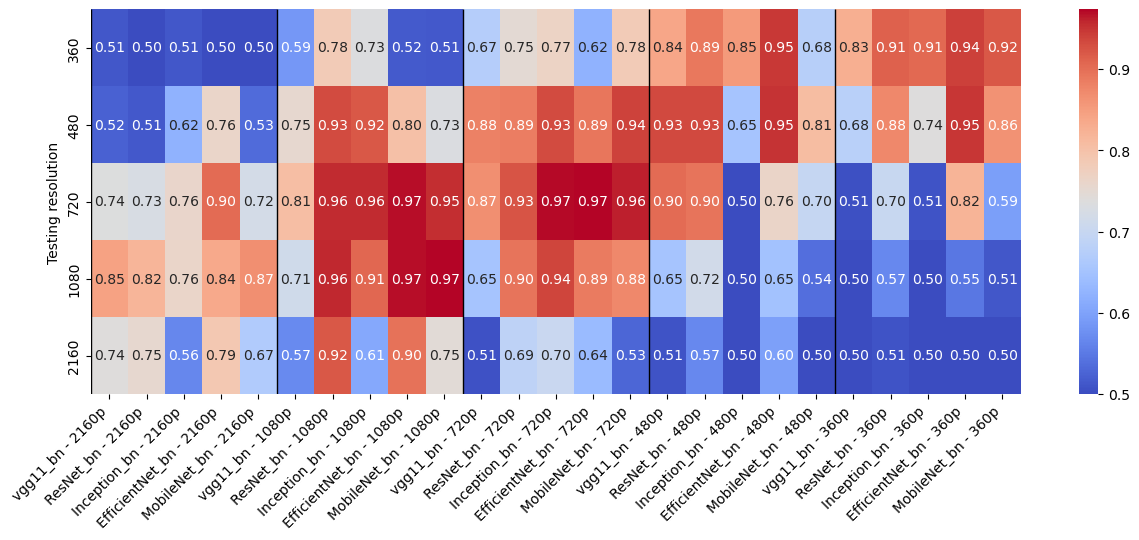

In [17]:
### Matrix heatmap grouped by resolution

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from Excel file
data = pd.read_excel(r"C:\ThesisMedia\CroppedPralines\Grouped_dataset\Thesis_Dataset_Resolution\Outputs\Testing_results.xlsx", header=0)

data.drop(['Test_Accuracy', 'Test_Recall', 'Test_Precision', 'Test_F1_Score'], axis=1, inplace=True)

# Concatenate the 'Type' column with 'X' and 'Y' columns
data['Res_train'] = data['Model'] + " - " + data['Train_resolution'].astype(str)
data['Res_test'] = data['Test_resolution'].astype(str).str.rstrip('p').astype(int)  # Remove 'p' from the resolution values

# Pivot the data to create a correlation matrix
correlation_data = data.pivot(index='Res_test', columns='Res_train', values='Test_mAP')

# Sort the unique Testing and Training resolution values in ascending order
sorted_resolutions_test = sorted(data['Res_test'].unique())

# Sort the column names (Res_train) based on the resolution values in descending order
sorted_resolutions_train = sorted(data['Res_train'].unique(), key=lambda x: int(x.split(" - ")[1].replace("p", "")), reverse=True)

# Reorder the rows and columns of the correlation matrix based on the sorted resolution values
correlation_data = correlation_data[sorted_resolutions_train]

# Create the correlation heatmap
plt.figure(figsize=(15, 5))
ax = sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt='.2f')

# Add thin vertical lines every 5 columns
for col in range(0, correlation_data.shape[1], 5):
    ax.vlines(col, *ax.get_ylim(), colors='black', linewidth=1)

# Rotate x-axis labels to have a slant (e.g., 45 degrees)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# plt.title("Test mAP Matrix heatmap")
# plt.xlabel("Model - Training resolution")
plt.xlabel("")
plt.ylabel("Testing resolution")
plt.show()

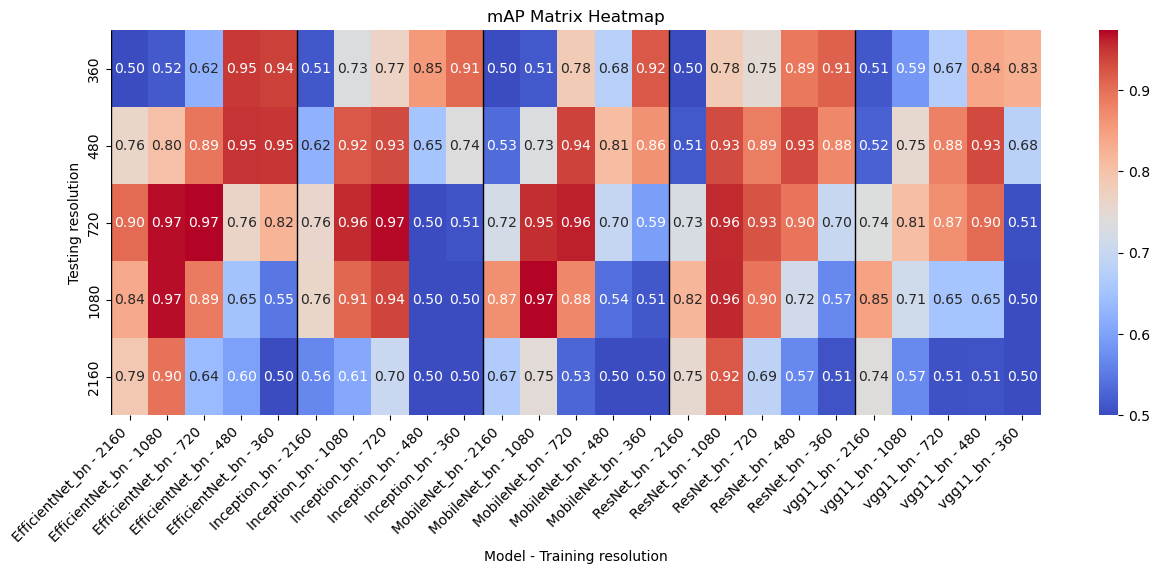

In [21]:
### Matrix heatmap grouped by model and resolution order

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from Excel file
data = pd.read_excel(r"C:\ThesisMedia\CroppedPralines\Grouped_dataset\Thesis_Dataset_Resolution\Outputs\Testing_results.xlsx", header=0)

data.drop(['Test_Accuracy', 'Test_Recall', 'Test_Precision', 'Test_F1_Score'], axis=1, inplace=True)

# Concatenate the 'Type' column with 'X' and 'Y' columns
data['Res_train'] = data['Model'] + " - " + data['Train_resolution'].astype(str)
data['Res_test'] = data['Test_resolution'].astype(str).str.rstrip('p').astype(int)  # Remove 'p' from the resolution values

# Pivot the data to create a correlation matrix
correlation_data = data.pivot(index='Res_test', columns='Res_train', values='Test_mAP')

# Sort the unique Testing and Training resolution values in ascending order
sorted_resolutions_test = sorted(data['Res_test'].unique(), reverse=True)

# Create a custom sort order function based on model names and resolution values
def custom_sort_order(col):
    model, resolution = col.split(" - ")
    return (model, -int(resolution.rstrip("p")))

# Sort the columns of the correlation matrix based on the custom sort order
sorted_columns = sorted(correlation_data.columns, key=custom_sort_order)
correlation_data = correlation_data[sorted_columns]

# Group x-axis labels by model
model_names = list(set(col.split(" - ")[0] for col in correlation_data.columns))
grouped_labels = [f"{model} - {res}" for model in model_names for res in sorted_resolutions_test]

# Create the correlation heatmap
plt.figure(figsize=(15, 5))
ax = sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt='.2f')

# Add thin vertical lines every 5 columns
for col in range(0, correlation_data.shape[1], 5):
    ax.vlines(col, *ax.get_ylim(), colors='black', linewidth=1)

# Set new x-axis labels with grouped model names and resolutions
# ax.set_xticks(range(correlation_data.shape[1]))
ax.set_xticklabels(grouped_labels, rotation=45, ha='right')

plt.title("mAP Matrix Heatmap")
plt.xlabel("Model - Training resolution")
plt.ylabel("Testing resolution")
plt.show()


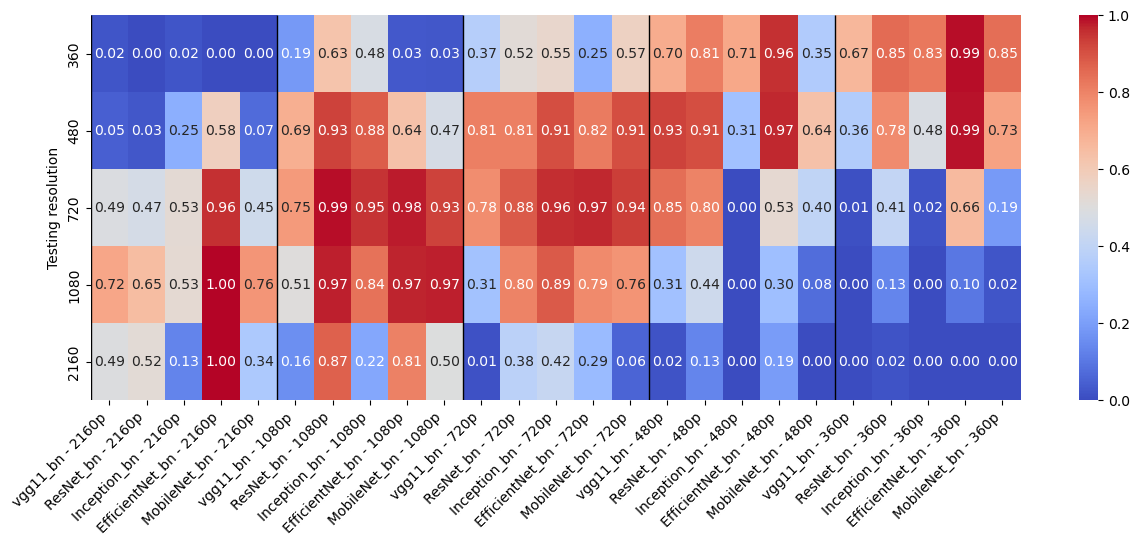

In [16]:
### Matrix heatmap grouped by resolution

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from Excel file
data = pd.read_excel(r"C:\ThesisMedia\CroppedPralines\Grouped_dataset\Thesis_Dataset_Resolution\Outputs\Testing_results.xlsx", header=0)

# data.drop(['Test_Accuracy', 'Test_Recall', 'Test_Precision', 'Test_F1_Score'], axis=1, inplace=True)

# Concatenate the 'Type' column with 'X' and 'Y' columns
data['Res_train'] = data['Model'] + " - " + data['Train_resolution'].astype(str)
data['Res_test'] = data['Test_resolution'].astype(str).str.rstrip('p').astype(int)  # Remove 'p' from the resolution values

# Pivot the data to create a correlation matrix
correlation_data = data.pivot(index='Res_test', columns='Res_train', values='Test_Recall')

# Sort the unique Testing and Training resolution values in ascending order
sorted_resolutions_test = sorted(data['Res_test'].unique())

# Sort the column names (Res_train) based on the resolution values in descending order
sorted_resolutions_train = sorted(data['Res_train'].unique(), key=lambda x: int(x.split(" - ")[1].replace("p", "")), reverse=True)

# Reorder the rows and columns of the correlation matrix based on the sorted resolution values
correlation_data = correlation_data[sorted_resolutions_train]

# Create the correlation heatmap
plt.figure(figsize=(15, 5))
ax = sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt='.2f')

# Add thin vertical lines every 5 columns
for col in range(0, correlation_data.shape[1], 5):
    ax.vlines(col, *ax.get_ylim(), colors='black', linewidth=1)

# Rotate x-axis labels to have a slant (e.g., 45 degrees)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# plt.title("Test Recall Matrix Heatmap")
# plt.xlabel("Model - Training resolution")
plt.xlabel("")
plt.ylabel("Testing resolution")
plt.show()